In [98]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pymc as pm
import seaborn as sns

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import first_level_gaussian_surprise
import numpy as np
import random

Comments:

- The version of Arviz that pyhgf uses currently has an issue with scipy, and it should be downgraded to <0.13.0. This can be done by running `!pip install scipy==0.12.0` in the notebook.
- Graphviz is not automatically installed when installing pyhgf, so it should be installed manually by running `!pip install graphviz` in the notebook.

Just use the YML file from the main Github repo.

In [99]:
# Set random seed
random.seed(42)

In [101]:
# Simulate an IGT deck of cards (deck 1)
num_trials = 700

# Deck 1 - 50% chance of -150 to -350
deck1 = []
for i in range(num_trials):
    x = 100
    if np.random.binomial(1, 0.5) == 1:
        x += random.choice([-150, -175, -200, -225, -250, -275, -300, -325, -350])
    else:
        pass
    # Downscaling
    x = x / 100
    deck1.append(x)

# Standardized version of the deck
deck1_std = []
for x in deck1:
    x = (x - np.mean(deck1)) / np.std(deck1)
    deck1_std.append(x)

[ 1.   -0.75  1.   -0.5  -1.5  -1.25  1.   -1.25 -1.    1.  ]


Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 700 new observations.


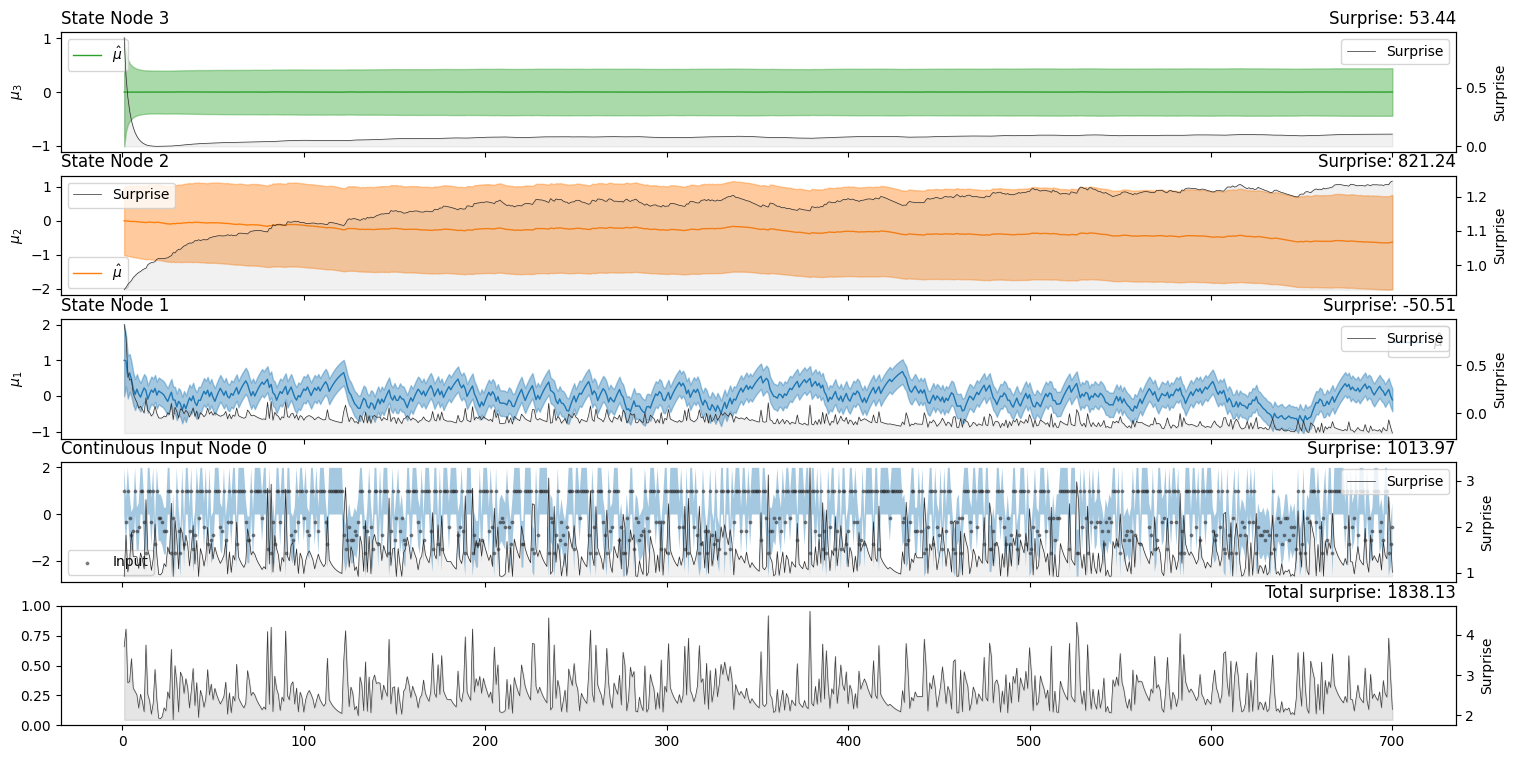

In [106]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4.0, precision = 1.0, mean = 1.0)
    .add_nodes(volatility_children=1, tonic_volatility=-4.0, precision = 1.0)
    .add_nodes(value_children=2, autoconnection_strength=0.8, precision = 1.0)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=np.asarray(deck1_std))

# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

In [107]:
df = two_levels_continuous_hgf.to_pandas()
df.tail(50)

,time_steps,time,observation_input_0,x_1_mean,x_1_precision,x_1_expected_mean,x_1_expected_precision,x_2_mean,x_2_precision,x_2_expected_mean,...,x_3_mean,x_3_precision,x_3_expected_mean,x_3_expected_precision,observation_input_0_surprise,observation_input_0_expected_precision,x_1_surprise,x_2_surprise,x_3_surprise,total_surprise
650,1.0,651.0,0.976830,-0.557053,10.465307,-0.719107,9.465307,-0.604414,0.560538,-0.617161,...,0.000352,5.835203,-0.000875,5.273226,2.357039,1.0,-0.080593,1.207131,0.087621,3.571199
651,1.0,652.0,-1.676422,-0.663933,10.473162,-0.557053,9.473162,-0.602974,0.558847,-0.604062,...,0.000385,5.826621,0.000282,5.271779,1.545432,1.0,-0.151186,1.213475,0.087755,2.695476
652,1.0,653.0,-0.160278,-0.615867,10.478302,-0.663933,9.478302,-0.608903,0.560525,-0.602589,...,-0.000292,5.817958,0.000308,5.264773,1.045773,1.0,-0.194615,1.214982,0.088420,2.154560
653,1.0,654.0,-0.349796,-0.590497,10.487842,-0.615867,9.487842,-0.616797,0.562717,-0.609195,...,-0.000959,5.812529,-0.000234,5.257699,0.954335,1.0,-0.203014,1.213502,0.089093,2.053917
654,1.0,655.0,0.976830,-0.441267,10.502730,-0.590497,9.502730,-0.607940,0.556948,-0.617756,...,0.000174,5.810241,-0.000767,5.253265,2.147196,1.0,-0.101040,1.211582,0.089516,3.347254
655,1.0,656.0,0.976830,-0.306300,10.506998,-0.441267,9.506998,-0.601059,0.552821,-0.607767,...,0.000776,5.802720,0.000139,5.251397,1.924438,1.0,-0.120486,1.216668,0.089693,3.110312
656,1.0,657.0,0.976830,-0.184147,10.504271,-0.306300,9.504271,-0.596219,0.550034,-0.600283,...,0.001005,5.792531,0.000621,5.245252,1.742150,1.0,-0.136024,1.220340,0.090277,2.916744
657,1.0,658.0,-0.349796,-0.199926,10.497643,-0.184147,9.497643,-0.603388,0.552738,-0.595214,...,0.000034,5.781474,0.000804,5.236926,0.932658,1.0,-0.205401,1.222856,0.091073,2.041187
658,1.0,659.0,0.976830,-0.087841,10.498722,-0.199926,9.498722,-0.601260,0.550797,-0.603354,...,0.000226,5.775083,0.000027,5.227885,1.611316,1.0,-0.146973,1.220412,0.091935,2.776690
659,1.0,660.0,-0.539314,-0.130848,10.497680,-0.087841,9.497680,-0.607827,0.552840,-0.601034,...,-0.000462,5.767956,0.000181,5.222660,1.020853,1.0,-0.197802,1.222164,0.092436,2.137651


Now let's simulate all 4 decks and make a model with 4 HGFs 

In [108]:
num_trials = 200

# Deck 1 - 50% chance of -150 to -350
deck1 = []
for i in range(num_trials):
    x = 100
    if np.random.binomial(1, 0.5) == 1:
        x += random.choice([-150, -175, -200, -225, -250, -275, -300, -325, -350])
    else:
        pass
    x = x / 100
    deck1.append(x)

# And now let's standardize the variables.
deck1_std = []

for x in deck1:
    x = (x - np.mean(deck1)) / np.std(deck1)
    deck1_std.append(x)

# Deck 2 - 10% chance of -1250
deck2 = []
for i in range(num_trials):
    x = 100
    if np.random.binomial(1, 0.1) == 1:
        x += -1250
    else:
        pass
    x = x / 100
    deck2.append(x)

# And now let's standardize the variables.
deck2_std = []

for x in deck2:
    x = (x - np.mean(deck2)) / np.std(deck2)
    deck2_std.append(x)

# Deck 3 - 50% chance of -25 to - 75
deck3 = []
for i in range(num_trials):
    x = 50
    if np.random.binomial(1, 0.5) == 1:
        x += random.choice([-25, -50, -75])
    else:
        pass
    x = x / 100
    deck3.append(x)

# And now let's standardize the variables.
deck3_std = []

for x in deck3:
    x = (x - np.mean(deck3)) / np.std(deck3)
    deck3_std.append(x)

# Deck 4 - 10% chance of -250
deck4 = []
for i in range(num_trials):
    x = 50
    if np.random.binomial(1, 0.1) == 1:
        x += -250
    else:
        pass
    x = x / 100
    deck4.append(x)

# And now let's standardize the variables.
deck4_std = []

for x in deck4:
    x = (x - np.mean(deck4)) / np.std(deck4)
    deck4_std.append(x)

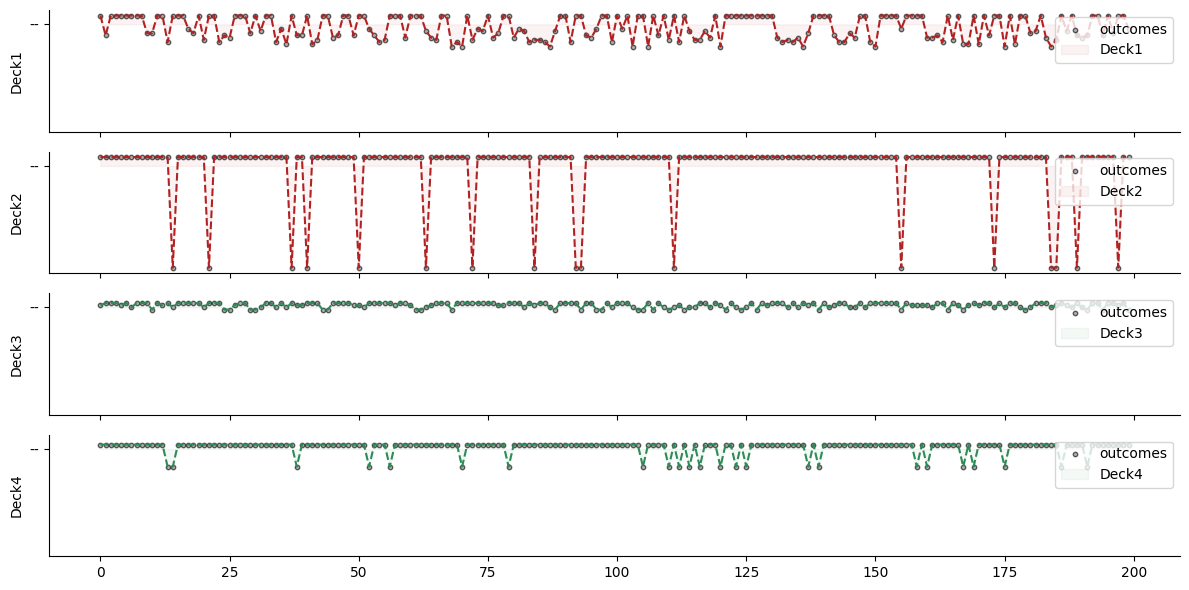

In [109]:
# Visualize the decks

# trial numbers
trials = np.arange(len(deck4))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

for i, u, p, label, color in zip(
    range(4),
    [deck1, deck2, deck3, deck4],
    [deck1, deck2, deck3, deck4],
    ["Deck1", "Deck2", "Deck3", "Deck4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"]):
    axs[i].scatter(trials, u, label="outcomes", alpha=.6, s=10, color="gray", edgecolor="k")
    axs[i].plot(trials, p, "--", color=color)
    axs[i].fill_between(trials, p, "--", label=label, color=color, alpha=.05)
    axs[i].legend(loc='upper right')
    axs[i].set_ylabel(label)
plt.tight_layout()
sns.despine();

Now we build a model with 4 HGFs, one for each deck. We will use the same parameters for all HGFs.

Initializing a network with custom node structure.


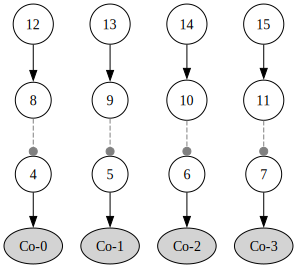

In [110]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [111]:
# Make our input vector
u = np.array([deck1_std, deck2_std, deck3_std, deck4_std])

In [112]:
# Lets feed our hgf the data
two_levels_continuous_hgf.input_data(input_data=u.T);

... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 200 new observations.


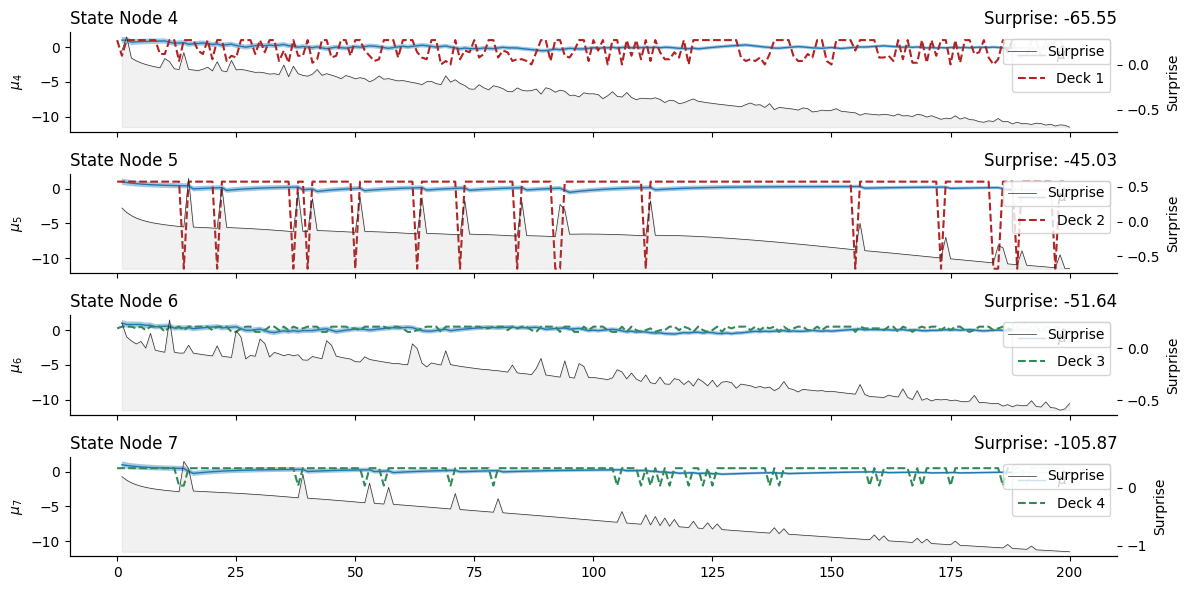

In [113]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [deck1, deck2, deck3, deck4],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

Simulate responses from the participant

In [114]:
# Something wrong with inverse heat here
beta = 1

v_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
v_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
v_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
v_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

def softmax(x, beta):
    """
    Compute the softmax of vector x using an inverse temperature parameter beta.

    Parameters:
    - x: Input vector
    - beta: Inverse temperature parameter

    Returns:
    - Softmax of the input vector x
    """
    x = np.array(x)
    exp_x = np.exp(beta * x)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

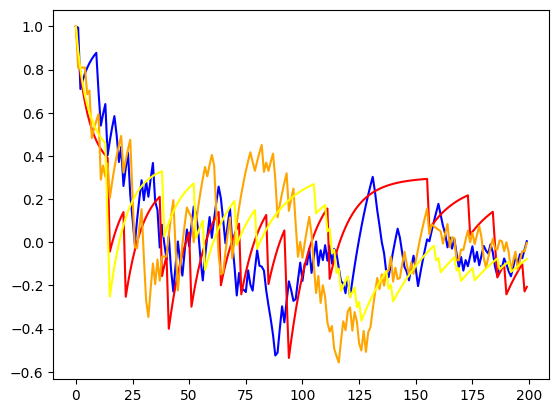

In [115]:
plt.plot(range(len(v_1)), v_1, color = "blue")
plt.plot(range(len(v_1)), v_2, color = "red")
plt.plot(range(len(v_1)), v_3, color = "orange")
plt.plot(range(len(v_1)), v_4, color = "yellow")

In [116]:
# Simulating choices for the participant
choices = []

for i in range(200):
    y = [v_1[i], v_2[i], v_3[i], v_4[i]]
    x = softmax(y, 4)
    choice = np.where(x == max(x))[0][0] # this should be a categorical_logit?
    choice = int(choice)
    choices.append(choice)

In [117]:
# a new matrix of observations
missing_inputs_u = u.astype(float)

# Create an observed array based on the choices made
observed = np.zeros(u.shape)

for i, c in enumerate(choices):
    observed[c, i] = 1

Make a new network

Initializing a network with custom node structure.


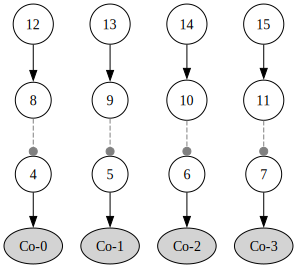

In [118]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [119]:
# note that we are providing the mask as parameter of the input function
two_levels_continuous_hgf.input_data(
    input_data=missing_inputs_u.T,
    observed=observed.T,
);

... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 200 new observations.


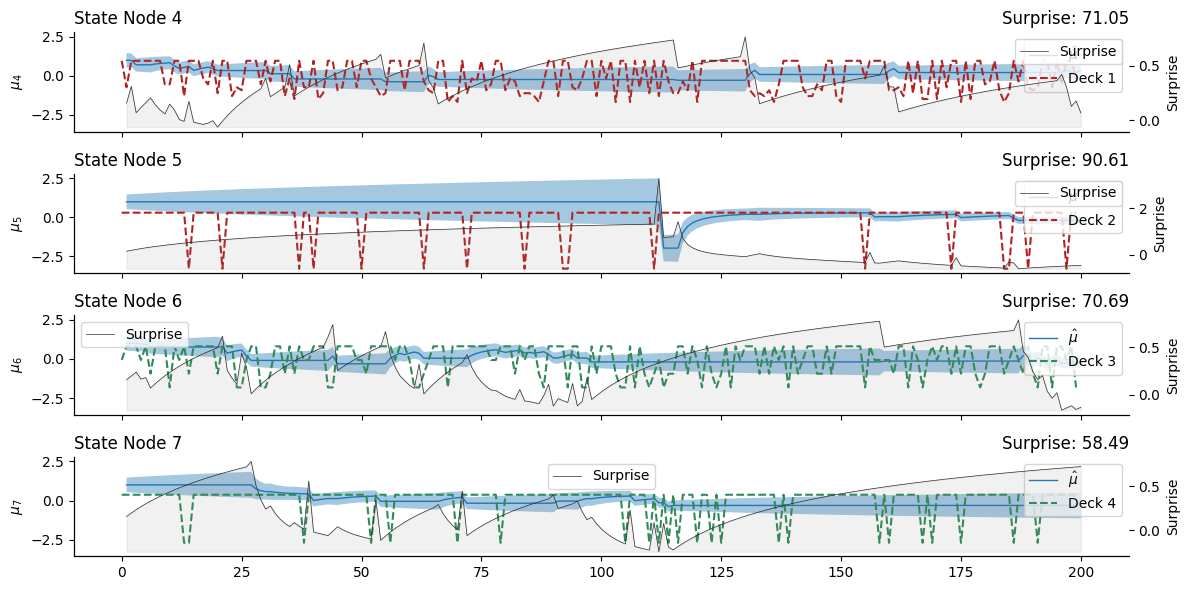

In [120]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [deck1_std, deck2_std, deck3_std, deck4_std],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

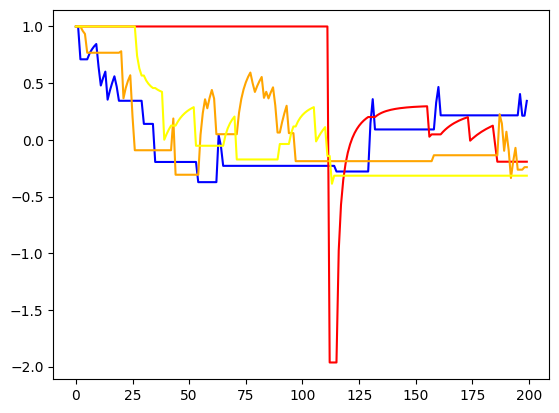

In [121]:
v_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
v_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
v_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
v_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

plt.plot(range(len(v_1)), v_1, color = "blue")
plt.plot(range(len(v_2)), v_2, color = "red")
plt.plot(range(len(v_3)), v_3, color = "orange")
plt.plot(range(len(v_4)), v_4, color = "yellow")

In [88]:
from pyhgf.networks import beliefs_propagation

Initializing a network with custom node structure.


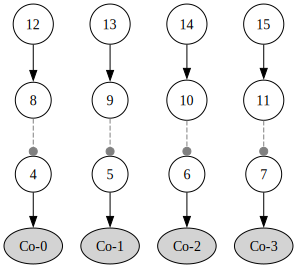

In [89]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [94]:
# get the network variables from the HGF class
attributes = two_levels_continuous_hgf.attributes
update_sequence = two_levels_continuous_hgf.update_sequence
edges = two_levels_continuous_hgf.edges
input_nodes_idx = two_levels_continuous_hgf.input_nodes_idx.idx

In [95]:
input_data = u.astype(float).T
responses = []  # 1: arm A - 0: arm B

# for each observation
for i in range(input_data.shape[0]):

    # the observation mask - default to 1
    observed = np.ones(4)

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    d_1 = attributes[4]["expected_mean"]
    d_2 = attributes[5]["expected_mean"]
    d_3 = attributes[6]["expected_mean"]
    d_4 = attributes[7]["expected_mean"]

    y = [d_1, d_2, d_3, d_4]
    x = softmax(y, 4)
    response = np.where(x == max(x))[0][0]
    response = int(response)

    responses.append(response)

    # hide the observations that were not selected
    observed[response] = 1

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        input_data=(input_data[i], time_steps, observed),
        update_sequence=update_sequence,
        edges=edges,
        input_nodes_idx=input_nodes_idx,
    )
responses = jnp.asarray(responses)  # vector of responses

TypeError: 'NoneType' object is not iterable